## Batch Ensemble Methods

In [ ]:
import numpy as np
import sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt


In [ ]:
X,y = load_breast_cancer(return_X_y=True)
X.shape, y.shape

((569, 30), (569,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train.shape, X_test.shape

((381, 30), (188, 30))

In [ ]:
model = BaggingClassifier()

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
f"Accuracy: {np.mean(n_scores)}, ({np.std(n_scores)})"
##  Bagging ensemble with default hyperparameters achieves a classification accuracy of about 94%

'Accuracy: 0.9537593984962405, (0.026208482535985338)'

In [ ]:
sorted(sklearn.metrics.SCORERS.keys()) 

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
n_scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
f"F1 score: {np.mean(n_scores)}, ({np.std(n_scores)})"
##  Bagging ensemble with default hyperparameters achieves a classification F1 score of about 0.96. Almost perfect score.

'F1 score: 0.9615822205587333, (0.018296811969348698)'

In [ ]:
## Let's train the model to use it to predict the future.
model = BaggingClassifier()
model.fit(X_train, y_train)
err = []
for xx,yy in zip(X_test,y_test):
  y_hat = model.predict(xx.reshape(1, -1))
  err.append(abs(y_hat-yy))

print(f"Accuracy: {1-np.sum(np.array(err))/len(err)}")

Accuracy: 0.9680851063829787


In [ ]:
## Instead of a loop on the data, we can do batch prediction
y_hat = model.predict(X_test)
print(y_hat.shape)


(188,)


In [ ]:
## What if we are not happy with default hyperparameters?

# get a list of models to evaluate. Each model will be defined by different hyperparameters
def create_models():
	models = dict()
	# define number of trees
	n_trees = [10, 50, 100, 500, 500, 1000, 5000]
	for n in n_trees:
		models[str(n)] = BaggingClassifier(n_estimators=n)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
	return scores
 

>10 0.956 (0.028)
>50 0.970 (0.022)
>100 0.969 (0.022)
>500 0.969 (0.015)
>1000 0.971 (0.017)
>5000 0.972 (0.023)


{'boxes': [<matplotlib.lines.Line2D at 0x7f2c9d2ca4d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2c9d2d8510>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2c9d2dea90>,
 'means': [<matplotlib.lines.Line2D at 0x7f2c9d2de550>,
 'medians': [<matplotlib.lines.Line2D at 0x7f2c9d2d8fd0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f2c9d2caa50>,
  <matplotlib.lines.Line2D at 0x7f2c9d243790>]}

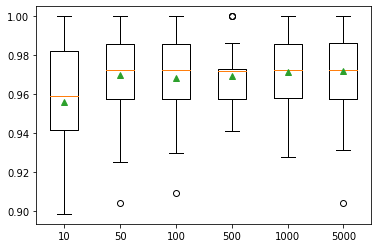

In [ ]:
## Running this cell will take a lot of time!
models = create_models()
# evaluate the models and store results
results = []
names = []
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)

## Ensemble methods for streams with river

In [ ]:
!pip install river

In [ ]:
from river import ensemble
from river import evaluate
from river import metrics
from river import optim
from river import preprocessing
from river import stream
from river import datasets
from river import tree
from river import linear_model
from river import neighbors

In [ ]:
## Classification task
dataset = datasets.Phishing()


In [ ]:
model = ensemble.BaggingClassifier(model=
                                   (preprocessing.StandardScaler() | 
                                    linear_model.LogisticRegression()), n_models=3)
metric = metrics.F1()

In [ ]:
evaluate.progressive_val_score(dataset, model, metric)

F1: 87.96%

In [ ]:
base_model = tree.HoeffdingTreeClassifier(grace_period=50, split_confidence=0.01)
#base_model = tree.SGTClassifier()
model = ensemble.BaggingClassifier(model= base_model, n_models=10)
metric = metrics.F1()

In [ ]:
evaluate.progressive_val_score(dataset, model, metric)

F1: 88.99%

In [ ]:
## With ADWIN drift detection

base_model = tree.HoeffdingTreeClassifier(grace_period=50, split_confidence=0.01)
#base_model = tree.SGTClassifier()
model = ensemble.ADWINBaggingClassifier(model= base_model, n_models=10)
metric = metrics.F1()

In [ ]:
evaluate.progressive_val_score(dataset, model, metric)

F1: 88.50%

In [ ]:
## Adaptive Random Forests
model = ensemble.AdaptiveRandomForestClassifier(n_models=3)
metric = metrics.F1()

In [ ]:
evaluate.progressive_val_score(dataset, model, metric)

F1: 89.37%

In [ ]:
## Regression task

dataset = dataset = datasets.TrumpApproval()

In [ ]:
model = preprocessing.StandardScaler()
model |= ensemble.BaggingRegressor(model=linear_model.LinearRegression(intercept_lr=0.1), n_models=3)

metric = metrics.MAE()

In [ ]:
evaluate.progressive_val_score(dataset, model, metric)

MAE: 0.726529

In [ ]:
base_model = tree.HoeffdingTreeRegressor(grace_period=5)
base_model = tree.SGTRegressor(grace_period=1)

model = ensemble.BaggingRegressor(model=base_model, n_models=10)

metric = metrics.MAE()

In [ ]:
evaluate.progressive_val_score(dataset, model, metric)

MAE: 1.228878

In [ ]:
#base_model = (preprocessing.StandardScaler() | neighbors.KNNRegressor(window_size=10))
base_model = neighbors.KNNRegressor(window_size=10)

model = ensemble.BaggingRegressor(model=base_model, n_models=3)

metric = metrics.MAE()

In [ ]:
evaluate.progressive_val_score(dataset, model, metric)

MAE: 0.352555

In [ ]:
## Adaptive Random Forest Regression

model = (preprocessing.StandardScaler() | ensemble.AdaptiveRandomForestRegressor(n_models=100))
metric = metrics.MAE()

In [ ]:
evaluate.progressive_val_score(dataset, model, metric)

MAE: 0.808674